In [1]:
!pip install segmentation-models-pytorch

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
resize = (256,256)
batch_size = 8
learning_rate = 0.0001
num_epochs = 60
save_path = 'PolypModel.pth'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
train_dir = '/kaggle/input/bkai-igh-neopolyp/train/train'
gt_dir = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'

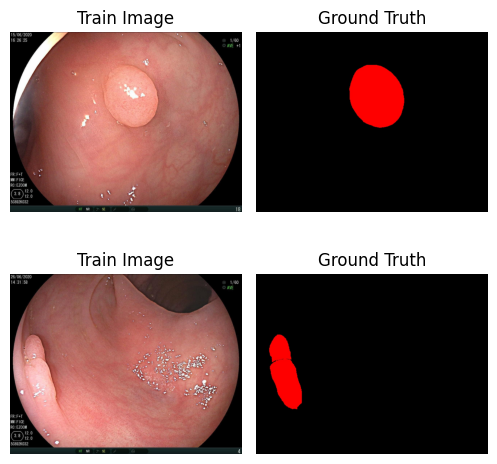

In [6]:
def visualize_random_train_gt_masks(train_dir, gt_dir):
    train_images = os.listdir(train_dir)

    selected_images = random.sample(train_images, 2)
    
    plt.figure(figsize=(10, 5))

    for i, selected_image in enumerate(selected_images):
        selected_gt_image = selected_image

        train_image = cv2.imread(os.path.join(train_dir, selected_image))
        gt_image = cv2.imread(os.path.join(gt_dir, selected_gt_image))

        train_image_rgb = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
        gt_image_rgb = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 4, i*4 + 1)
        plt.imshow(train_image_rgb)
        plt.title("Train Image")
        plt.axis('off')

        plt.subplot(2, 4, i*4 + 2)
        plt.imshow(gt_image_rgb)
        plt.title("Ground Truth")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_train_gt_masks(train_dir, gt_dir)

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 2

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 1

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [8]:
image_path = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)
        
len(image_path)

1000

In [9]:
mask_path = []
for root, dirs, files in os.walk(gt_dir):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
        
len(mask_path)

1000

In [10]:
dataset = CustomImageDataset(img_dir= train_dir,
                             label_dir= gt_dir,
                             resize= resize,
                             transform = None)

In [11]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
).to(device)

In [12]:
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [13]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


In [14]:
def dice_coefficient_for_classes(pred, target, class_id=1):
    pred_c = (pred == class_id)
    target_c = (target == class_id)

    intersection = (pred_c * target_c).sum()
    total = pred_c.sum() + target_c.sum()
    if total == 0:
        return 1
    dice_score = (2. * intersection) / (total)
    return float(dice_score)

In [15]:
import torch.nn.functional as F
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
    def forward(self, preds, targets):
        batch_loss = 0.0
        batch_size = targets.size(0)
        
        for i in range(batch_size):
            loss = F.cross_entropy(preds[i].unsqueeze(0), targets[i].unsqueeze(0))
            pred_classes = preds[i].argmax(dim=0)
            dice_1 = dice_coefficient_for_classes(pred_classes, targets[i],1)
            dice_2 = dice_coefficient_for_classes(pred_classes, targets[i],2)
            loss += 1- dice_1 + 1 - dice_2
            batch_loss += loss
        
        return batch_loss / batch_size


In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
#criterion = CombinedLoss()

In [17]:
!pip install wandb
import wandb
!wandb login ''
wandb.init(
    project = 'BKAI_IGH_NeoPolyp'
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: dodoanhoangdu (dodoanhoangdu-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


In [18]:
best_val_loss = 999
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss/len(train_loader)
              })

Epoch [1/60], Loss: 0.2824317675
Save new model
Epoch [2/60], Loss: 0.1548368782
Save new model
Epoch [3/60], Loss: 0.1067332574
Save new model
Epoch [4/60], Loss: 0.0868382273
Save new model
Epoch [5/60], Loss: 0.0733289234
Save new model
Epoch [6/60], Loss: 0.0683085681
Save new model
Epoch [7/60], Loss: 0.0667616917
Save new model
Epoch [8/60], Loss: 0.0775303448
Epoch [9/60], Loss: 0.0691841935
Epoch [10/60], Loss: 0.0551564663
Save new model
Epoch [11/60], Loss: 0.0529864939
Save new model
Epoch [12/60], Loss: 0.0531731352
Epoch [13/60], Loss: 0.0478476554
Save new model
Epoch [14/60], Loss: 0.0523734686
Epoch [15/60], Loss: 0.0510032926
Epoch [16/60], Loss: 0.0468956767
Save new model
Epoch [17/60], Loss: 0.0487011685
Epoch [18/60], Loss: 0.0610361727
Epoch [19/60], Loss: 0.0480852635
Epoch [20/60], Loss: 0.0469725830
Epoch [21/60], Loss: 0.0511091293
Epoch [22/60], Loss: 0.0517983396
Epoch [23/60], Loss: 0.0906723040
Epoch [24/60], Loss: 0.0554131332
Epoch [25/60], Loss: 0.05553

In [19]:
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

Ground Truth Pixel Counts: {0: 64962, 1: 574, 2: 0}
Predicted Target Pixel Counts: {0: 64935, 1: 601, 2: 0}
Dice Score for Class 0: 0.9993
Dice Score for Class 1: 0.9174
Dice Score for Class 2: 1.0000


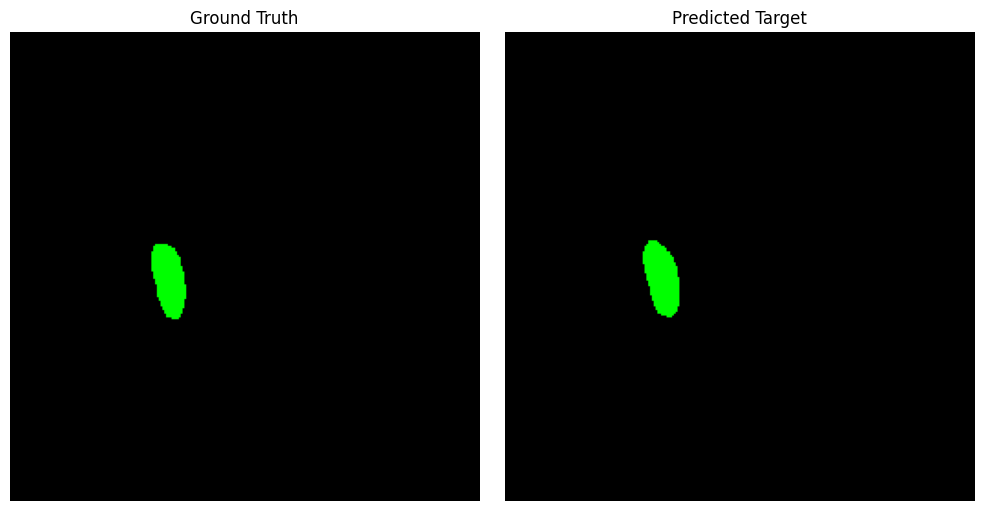

Ground Truth Pixel Counts: {0: 62703, 1: 0, 2: 2833}
Predicted Target Pixel Counts: {0: 62614, 1: 0, 2: 2922}
Dice Score for Class 0: 0.9991
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9804


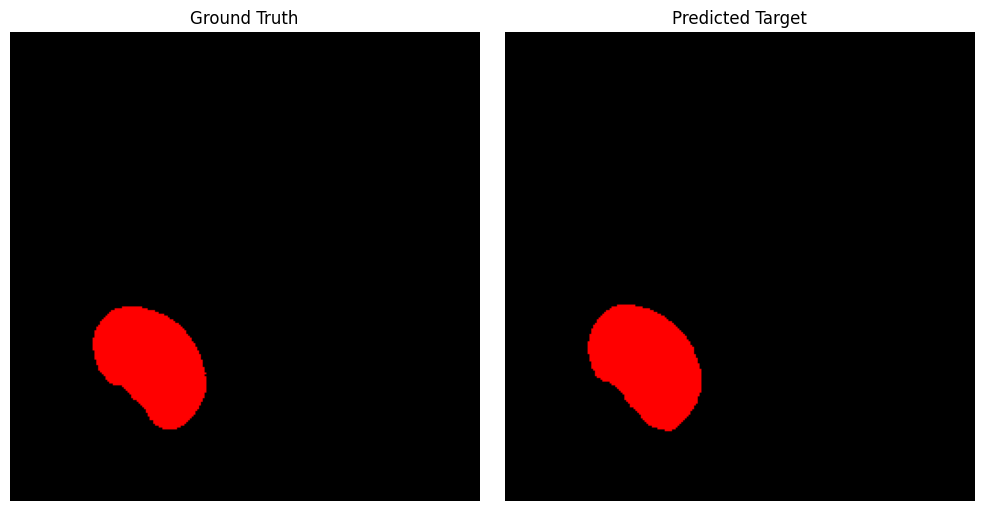

Ground Truth Pixel Counts: {0: 64750, 1: 0, 2: 786}
Predicted Target Pixel Counts: {0: 64601, 1: 0, 2: 935}
Dice Score for Class 0: 0.9988
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9123


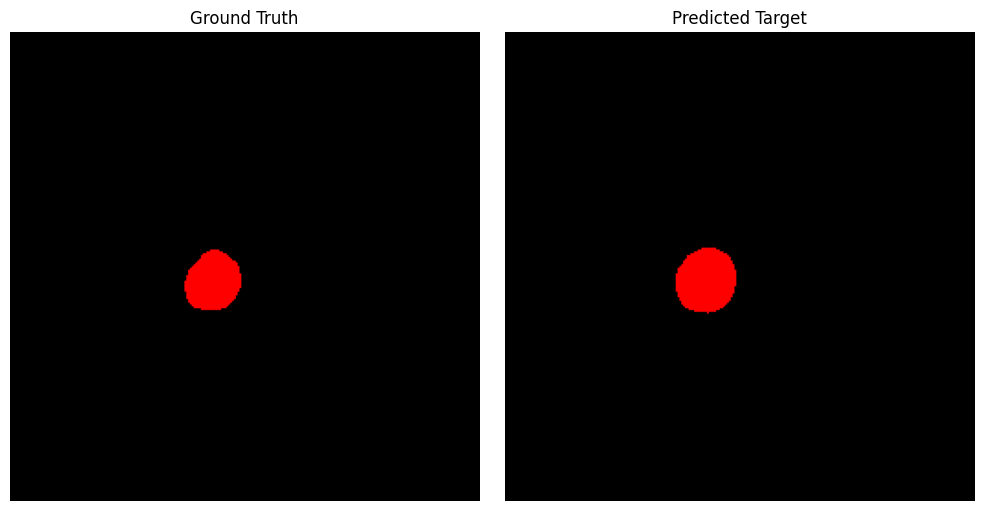

Ground Truth Pixel Counts: {0: 63156, 1: 0, 2: 2380}
Predicted Target Pixel Counts: {0: 63434, 1: 0, 2: 2102}
Dice Score for Class 0: 0.9974
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9273


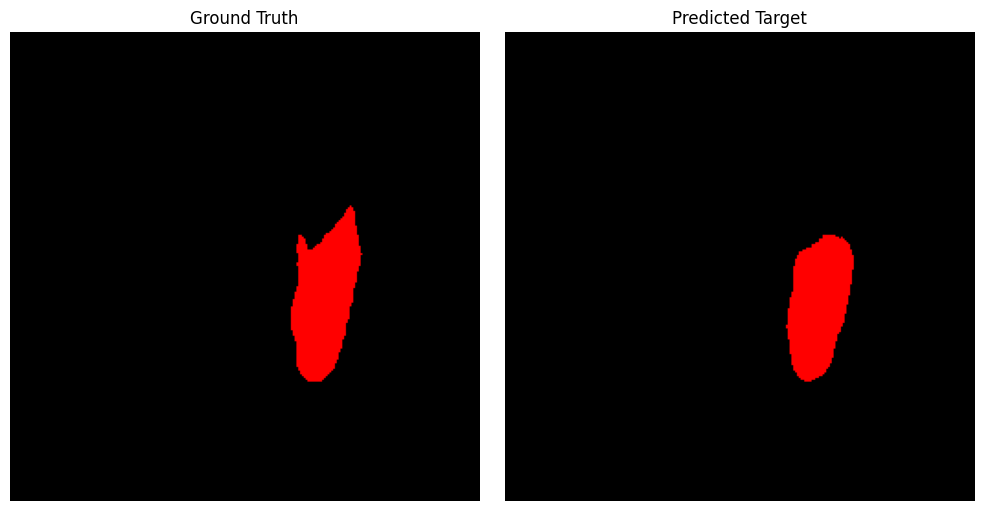

Ground Truth Pixel Counts: {0: 64750, 1: 0, 2: 786}
Predicted Target Pixel Counts: {0: 64601, 1: 0, 2: 935}
Dice Score for Class 0: 0.9988
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9123


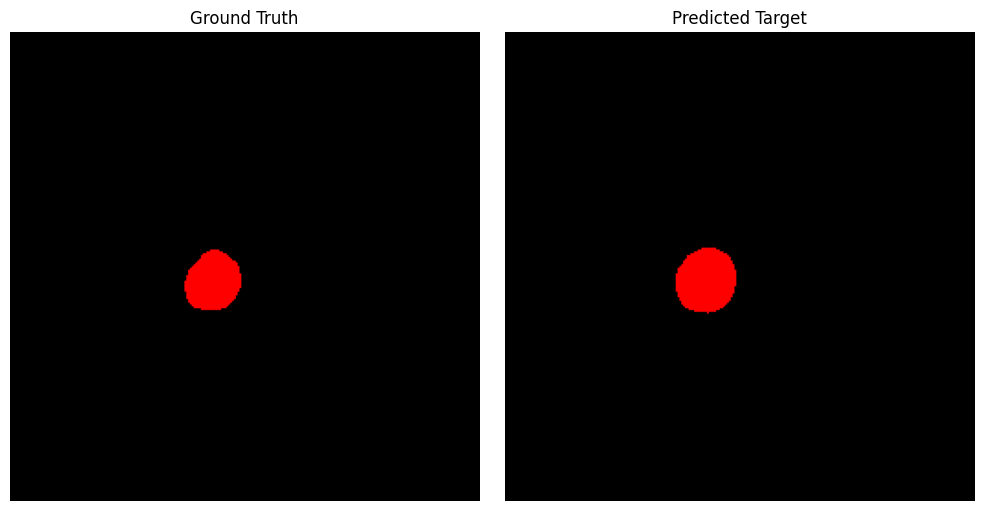

Ground Truth Pixel Counts: {0: 64889, 1: 0, 2: 647}
Predicted Target Pixel Counts: {0: 65310, 1: 226, 2: 0}
Dice Score for Class 0: 0.9968
Dice Score for Class 1: 0.0000
Dice Score for Class 2: 0.0000


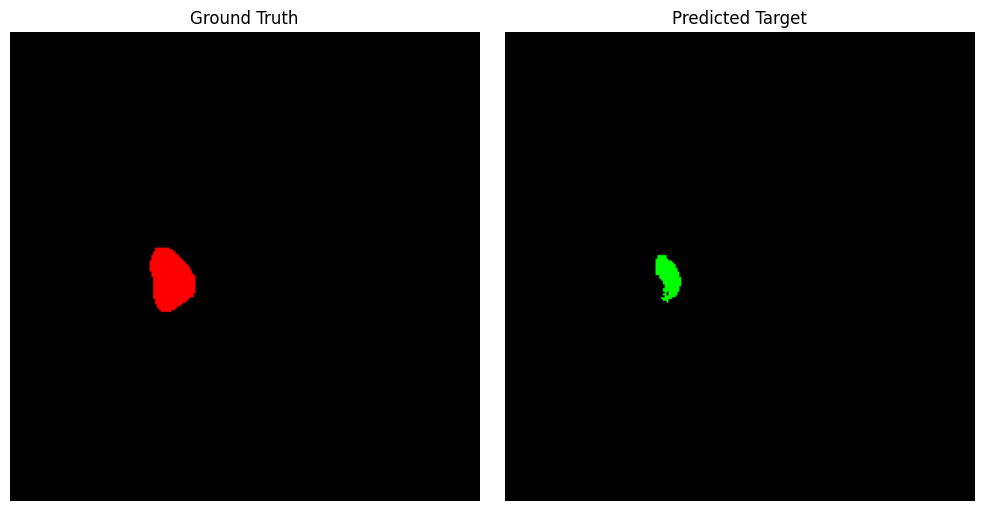

Ground Truth Pixel Counts: {0: 58384, 1: 0, 2: 7152}
Predicted Target Pixel Counts: {0: 58426, 1: 0, 2: 7110}
Dice Score for Class 0: 0.9983
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9860


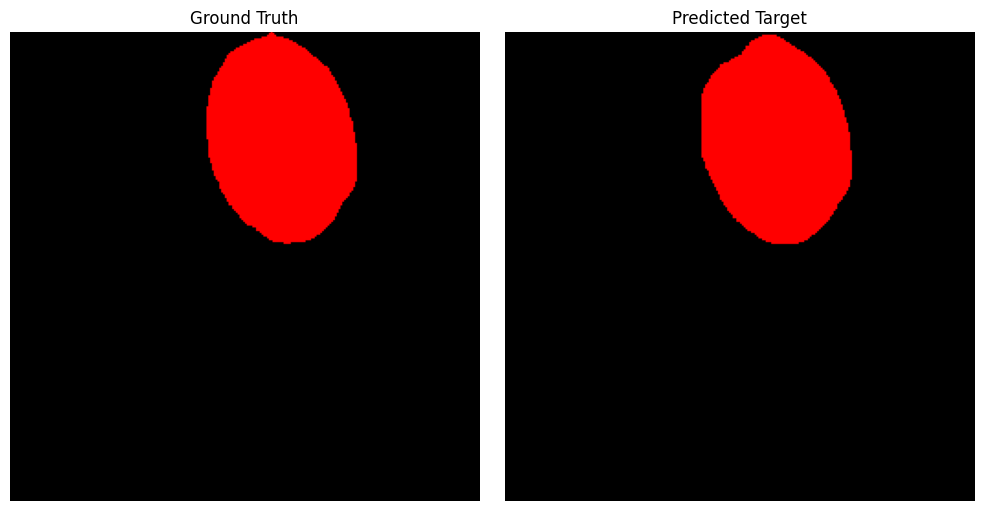

Ground Truth Pixel Counts: {0: 64101, 1: 0, 2: 1435}
Predicted Target Pixel Counts: {0: 64082, 1: 0, 2: 1454}
Dice Score for Class 0: 0.9994
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9754


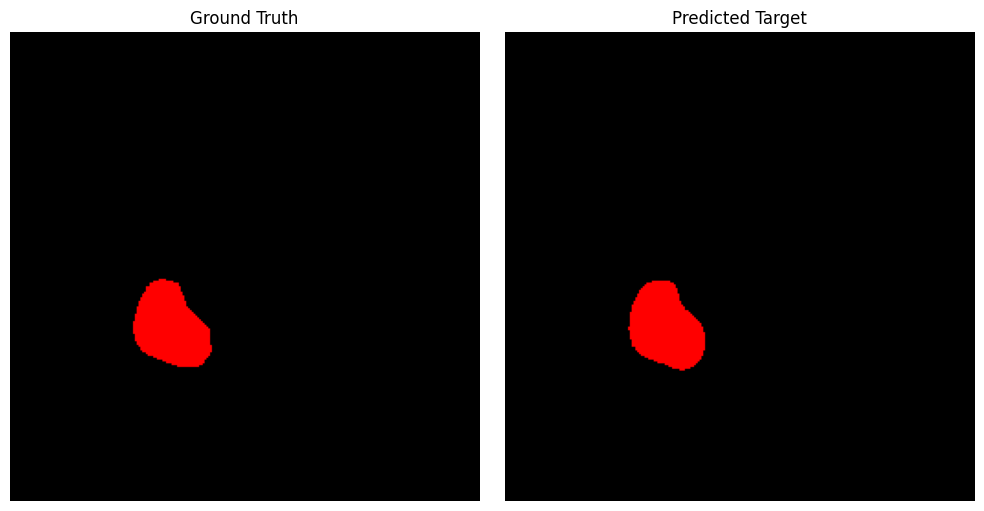

Ground Truth Pixel Counts: {0: 61173, 1: 0, 2: 4363}
Predicted Target Pixel Counts: {0: 61154, 1: 0, 2: 4382}
Dice Score for Class 0: 0.9993
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.9907


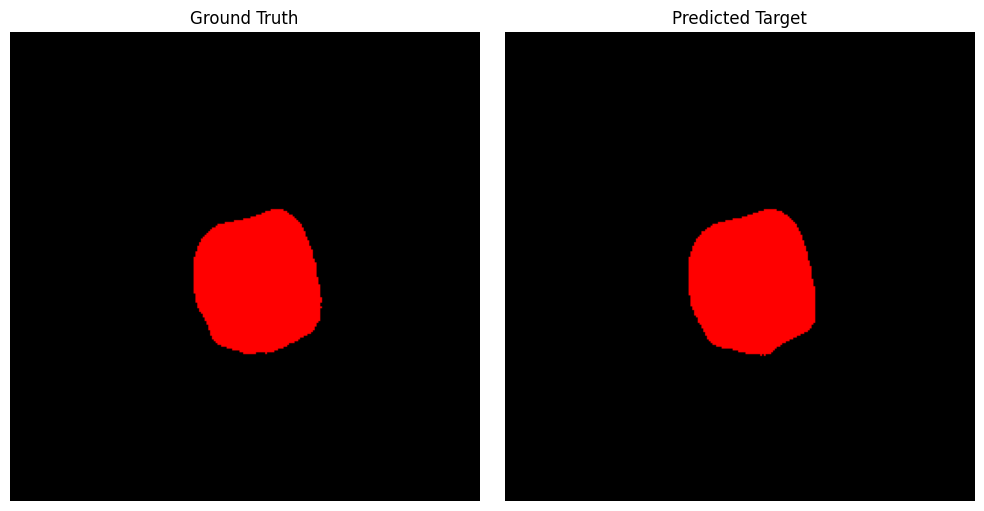

Ground Truth Pixel Counts: {0: 64501, 1: 0, 2: 1035}
Predicted Target Pixel Counts: {0: 64268, 1: 0, 2: 1268}
Dice Score for Class 0: 0.9976
Dice Score for Class 1: 1.0000
Dice Score for Class 2: 0.8658


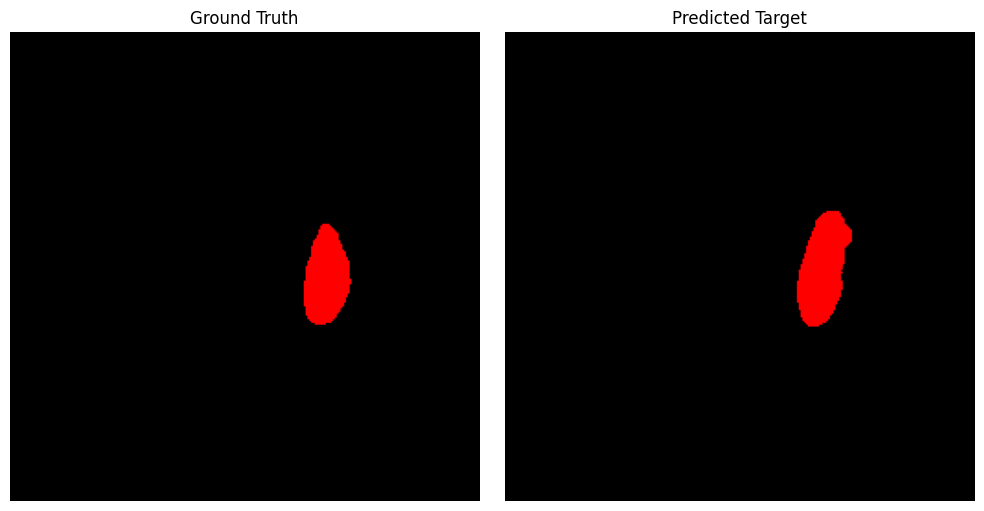

In [20]:
import time
def visualize_model_output(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    input_image = image.unsqueeze(0).to(device)
    target = target.numpy().squeeze()

    with torch.no_grad():
        output = model(input_image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    target_pixel_counts = {cls: (target == cls).sum() for cls in range(3)}
    prediction_pixel_counts = {cls: (prediction == cls).sum() for cls in range(3)}

    print("Ground Truth Pixel Counts:", target_pixel_counts)
    print("Predicted Target Pixel Counts:", prediction_pixel_counts)
    dice_scores = {}
    for class_id in range(3): 
        dice_score = dice_coefficient_for_classes(prediction, target, class_id)
        dice_scores[class_id] = dice_score
        print(f"Dice Score for Class {class_id}: {dice_score:.4f}")

    def apply_colormap(mask):
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        colored_mask[mask == 1] = [0, 255, 0]  # Green for 1
        colored_mask[mask == 2] = [255, 0, 0]  # Red for 2
        return colored_mask

    target_colored = apply_colormap(target)
    prediction_colored = apply_colormap(prediction)

    plt.figure(figsize=(15, 5))

    """
    plt.subplot(1, 3, 1)
    plt.imshow(image)  # Convert CHW to HWC
    plt.title("Input Image")
    plt.axis('off')
    """

    plt.subplot(1, 3, 2)
    plt.imshow(target_colored)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_colored)
    plt.title("Predicted Target")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Visualize the model's output
for i in range(10):
    time.sleep(1)
    visualize_model_output(model, val_dataset, device)


In [21]:
!mkdir prediction

mkdir: cannot create directory ‘prediction’: File exists


In [22]:
color_dict= {0: (0, 0, 0),
             1: (0, 255, 0),
             2: (255, 0, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (resize[0], resize[1]))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb) 

In [23]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/kaggle/working/prediction/85a04faeeb2b535797395305af926a6f.jpeg
/kaggle/working/prediction/4ef4d95ceea11957998906d3694abb47.jpeg
/kaggle/working/prediction/998906d3694abb47953b0e4909384b57.jpeg
/kaggle/working/prediction/6240619ebebe9e9c9d00a4262b4fe4a5.jpeg
/kaggle/working/prediction/c695325ded465efde988dfb96d081533.jpeg
/kaggle/working/prediction/d077bad31c8c5f54ffaa27a623511c38.jpeg
/kaggle/working/prediction/cc5cfd263f1f90be28799235026b3550.jpeg
/kaggle/working/prediction/782707d7c359e27888daefee82519763.jpeg
/kaggle/working/prediction/4fda8daadc8dd23ae214d84b5dec33fd.jpeg
/kaggle/working/prediction/15fc656702fa602bb3c7abacdbd7e6af.jpeg
/kaggle/working/prediction/2d9e593b6be1ac29adbe86f03d900fd1.jpeg
/kaggle/working/prediction/cb1b387133b51209db6dcdda5cc8a788.jpeg
/kaggle/working/prediction/be4d18d5401f659532897255ce2dd4ae.jpeg
/kaggle/working/prediction/dd094a7f32574d6c748c41743c6c08a1.jpeg
/kaggle/working/prediction/e4a17af18f72c8e6166a915669c99390.jpeg
/kaggle/working/predictio